In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import sklearn.feature_extraction.image as skimage
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.nn.functional as F
import torch
from torch.utils.data import DataLoader
import random
import torch.optim as optim
import time

In [3]:
# loading silhouettes and solutions
silhouettes = np.load("silhouettes_adjusted.npy")

## Helper

In [4]:
def crop(silhouette):
    y,x = np.where(silhouette > 0)
    min_y = np.min(y)
    max_y = np.max(y)
    min_x = np.min(x)
    max_x = np.max(x)
    c = silhouette[min_y:max_y+1 , min_x:max_x+1]
    return c

In [5]:
def get_binary_silhouette(silhouette):
    binary = np.copy(silhouette)
    binary[binary>0]=1
    return binary

In [6]:
def place_building_block(bb_id, position):
    x,y = position
    building_blocks = [[(0,0),(1,0),(0,1)],
                       [(0,0),(1,0),(1,1)],
                       [(0,0),(0,1),(-1,1)],
                       [(0,0),(0,1),(1,1)],
                       [(0,0),(1,0),(2,0)],
                       [(0,0),(0,1),(0,2)],
                       []
                      ]
    bb = building_blocks[bb_id]
    return [(x+i, y+j) for (i,j) in bb]

In [7]:
def get_docking_point(bb_id, position, neighbor_position, neighbor_id):
    x,y = position
    n_width, n_height = get_width_height(neighbor_id)
    
    mapping = {"left": [(x-n_width, y), (x-n_width,y), (x-n_width,y), (x-n_width,y), (x-n_width,y), (x-n_width,y+1),(x,y)], 
               "right": [(x+2, y), (x+2,y), (x+1,y), (x+2,y+1), (x+3,y), (x+1,y+1),(x,y)],
               "top": [(x, y-n_height),(x,y-n_height), (x+1,y-n_height-1), (x,y-n_height), (x+1,y-n_height), (x,y-n_height),(x,y)], 
               "bottom": [(x, y+2),(x+1,y+2), (x,y+1), (x,y+2), (x+1,y+1), (x,y+3),(x,y)]}
    
    mapping2 = {"left": [(x-1, y), (x-1,y), (x-1,y), (x-1,y), (x-1,y), (x-1,y+1),(x,y)], 
               "right": [(x+n_width+1, y), (x+n_width+1,y), (x+n_width,y), (x+n_width+1,y+1), (x+n_width+2,y), (x+n_width,y+1),(x,y)],
               "top": [(x+1, y-n_height),(x+1,y-n_height), (x+2,y-n_height-1), (x+1,y-n_height), (x+2,y-n_height), (x+1,y-n_height),(x,y)], 
               "bottom": [(x, y+2),(x+1,y+2), (x,y+1), (x,y+2), (x+1,y+1), (x,y+3),(x,y)]}
    
    if neighbor_id == 2:
        return mapping2[neighbor_position][bb_id]
    else:
        return mapping[neighbor_position][bb_id]

In [8]:
def get_width_height(bb_id):
    building_blocks = [(2,2), (2,2), (2,2), (2,2), (3,1), (1,3),(0,0)]
    return building_blocks[bb_id]

In [9]:
def fill_pixel(scene, pixel):
    for p in pixel:
        scene[p[1], p[0]] = 1
    

In [10]:
def draw_silhouette(edges,positions):
    placed = []
    scene = np.zeros((10,10))
    if len(edges) == 0:
        return scene
    
    
    pos = (3,3)
    a = edges[0][0]
    fill_pixel(scene, place_building_block(a,pos))
    placed.append(a)
    
    next_block = []
    next_pos = []
    
    while True:
        for i,e in enumerate(edges):
            if e[0] ==a:
                b = e[1]
                if b not in placed:
                    n = get_docking_point(a, pos, positions[i], b)
                    fill_pixel(scene, place_building_block(b,n))
                    placed.append(b)
                    if b not in next_block:
                        next_block.append(b)
                        next_pos.append(n)
        if len(next_block) == 0:
            break
        a = next_block.pop()
        pos = next_pos.pop()
        
    return scene
    

## Environment

In [11]:
class Env():
    def __init__(self, silhouettes):
        self.silhouettes = silhouettes
        self.current_silhouette = None
        self.num_actions = 0
        self.current_graph = ()
        self.edges = []
        self.positions = []
    
    def reset(self):
        idx = random.randint(0,len(self.silhouettes)-1)
        self.current_silhouette = self.silhouettes[idx]
        self.num_actions = 0
        vertices = [[i,0] for i in range(6)]
        vertices.append([6,1]) # initial block for placing the first block in an empty scene
        vertives = np.array(vertices)
        edges = np.zeros((7,7,4))
        self.current_graph = (vertices, edges, get_binary_silhouette(self.current_silhouette),np.zeros((7*7*4)))
        self.edges = []
        self.positions = []
        return self.current_graph
        
    def step(self, action):
        self.num_actions += 1
        sender, receiver, rel_position = action
        action_idx = sender*28+receiver*4+rel_position
        if self.valid(sender, receiver, rel_position):
            self.edges.append((sender,receiver))
            self.positions.append(["left", "right", "top", "bottom"][rel_position])
            
            # place the sender node in the scene
            self.current_graph[0][sender][1] = 1
            self.current_graph[3][action_idx] = 1
            # adjust the edge between sender and receiver
            if receiver == 6:
                # initial block is just a helper and can only be used once (for the very first block)
                self.current_graph[1][sender, receiver] = [1,1,1,1] 
            else:
                self.current_graph[1][sender, receiver, rel_position] = 1
            done = self.num_actions >= 3
            reward = 1
        else:
            done = True
            reward = 0
        
#         reward = 0
#         if len(self.edges) > 0:
#             # draw blocks
#             scene = draw_silhouette(self.edges, self.positions)
#             sil_crop = crop(self.current_silhouette)
#             scene_crop = crop(scene)
#             pixel_coordinates = np.argwhere(sil_crop == 1)
#             for p in pixel_coordinates:
#                 if scene_crop.shape[0] > p[0] and scene_crop.shape[1] > p[1]: 
#                     if scene_crop[p[0], p[1]] == 1:
#                         reward += 1

        return self.current_graph, reward, done
            
        
    def valid(self, sender, receiver, rel_position):
        # sender has to be available, receiver has to be placed
        if self.current_graph[0][sender][1] == 1 or self.current_graph[0][receiver][1] == 0:
            return False
        # get all edges to the receiver
        e_r = self.current_graph[1][:,receiver]
        for e in e_r:
            # if any other block is connected to the receiver with the same relative position, this action is illegal
            if e[rel_position] == 1:
                return False
        return True
        
    

In [12]:
class TestEnv():
    def __init__(self, silhouettes):
        self.silhouettes = silhouettes
        self.current_silhouette = None
        self.num_actions = 0
        self.current_graph = ()
        self.edges = []
        self.positions = []
    
    def reset(self):
        idx = random.randint(0,len(self.silhouettes)-1)
        self.current_silhouette = self.silhouettes[idx]
        self.num_actions = 0
        vertices = [[i,0] for i in range(6)]
        vertices.append([6,1]) # initial block for placing the first block in an empty scene
        vertives = np.array(vertices)
        edges = np.zeros((7,7,4))
        self.current_graph = (vertices, edges, get_binary_silhouette(self.current_silhouette))
        self.edges = []
        self.positions = []
        return self.current_graph
        
    def step(self, action):
        self.num_actions += 1        
        done = self.num_actions >= 3
        action = action[0]*28 + action[1]*4 + action[2]
        if action in list(range(20)):
            reward = 1
        else:
            reward = 0
            
        return self.current_graph, reward, done
            
        
    def valid(self, sender, receiver, rel_position):
        # sender has to be available, receiver has to be placed
        if self.current_graph[0][sender][1] == 1 or self.current_graph[0][receiver][1] == 0:
            return False
        # get all edges to the receiver
        e_r = self.current_graph[1][:,receiver]
        for e in e_r:
            # if any other block is connected to the receiver with the same relative position, this action is illegal
            if e[rel_position] == 1:
                return False
        return True
        
    

## DQN

In [13]:
# class DeepQNetwork(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.device = torch.device('cpu')
#         self.num_iterations = 3
#         lr = 0.003
        
#         self.relu = nn.ReLU().to(self.device)
#         self.global_embedding_conv1 = nn.Conv2d(in_channels=1, out_channels=4, stride=2, kernel_size=4, padding=2).to(self.device)
#         self.global_embedding_conv2 = nn.Conv2d(in_channels=4, out_channels=5, stride=2, kernel_size=3).to(self.device)
#         self.global_embedding_fc1 = nn.Linear(20, 32).to(self.device)
#         self.global_embedding_fc2 = nn.Linear(32, 16).to(self.device)
        
#         self.vertices_embedding_fc1 = nn.Linear(2, 8).to(self.device)
#         self.vertices_embedding_fc2 = nn.Linear(8, 16).to(self.device)
        
#         self.edges_embedding_fc1 = nn.Linear(4, 8).to(self.device)
#         self.edges_embedding_fc2 = nn.Linear(8, 16).to(self.device)
        
#         self.edges_fc1 = nn.Linear(64, 32).to(self.device)
#         self.edges_fc2 = nn.Linear(32, 16).to(self.device)
        
#         self.vertices_fc1 = nn.Linear(48, 32).to(self.device)
#         self.vertices_fc2 = nn.Linear(32, 16).to(self.device)


#         self.edges_decode_fc1 = nn.Linear(16, 8).to(self.device)
#         self.edges_decode_fc2 = nn.Linear(8, 4).to(self.device)
        
        
#         # optimizer
#         self.optimizer = optim.Adam(self.parameters(), lr=lr)
#         self.loss = nn.MSELoss()
#         self.to(self.device)


#     def forward(self, g):
#         V,E,U = g
#         V = torch.tensor(V).float().to(self.device)
#         E = torch.tensor(E).reshape((49,4)).float().to(self.device)
#         U = torch.tensor(U).reshape((1,1,10,10)).float().to(self.device)
        
#         # encoding vertices embedding
#         V = self.relu(self.vertices_embedding_fc1(V))
#         V = self.vertices_embedding_fc2(V)
        
#         # encoding edges embedding 
#         E = self.relu(self.edges_embedding_fc1(E))
#         E = self.edges_embedding_fc2(E)
        
#         # encoding global embedding
#         U = self.global_embedding_conv1(U)
#         U = self.global_embedding_conv2(U)
#         U = torch.flatten(U, 1)
#         U = self.relu(self.global_embedding_fc1(U))
#         U = self.global_embedding_fc2(U)
        
        
#         for k in range(self.num_iterations):
#             # Update edges
#             edges = torch.empty((len(E),64))
#             for i,e in enumerate(E):
#                 sender = i//7
#                 receiver = i%7
#                 edges[i] = torch.cat((e,V[sender], V[receiver], U[0])) 
#                 #edges.append(e)
#             E = edges
#             E = self.relu(self.edges_fc1(E))
#             E = self.edges_fc2(E)
            
#             # Update vertices
#             vertices = torch.empty((len(V),48))
#             for i,v in enumerate(V):
#                 edges_in = E.reshape(7,7,16)[:,i]
#                 e_accum = torch.sum(edges_in, axis=0)
#                 vertices[i] = torch.cat((v,e_accum,U[0]))
#             V = vertices   
#             V = self.relu(self.vertices_fc1(V))
#             V = self.vertices_fc2(V)
            
        
#         # decode q_values
#         E = self.relu(self.edges_decode_fc1(E))
#         q_values = self.edges_decode_fc2(E)
        
#         return q_values

In [34]:
class DeepQNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.device = torch.device('cpu')
        self.num_iterations = 3
        lr = 0.0003
        
        self.relu = nn.ReLU().to(self.device)
        self.global_embedding_conv1 = nn.Conv2d(in_channels=1, out_channels=4, stride=2, kernel_size=4, padding=2).to(self.device)
        self.global_embedding_conv2 = nn.Conv2d(in_channels=4, out_channels=5, stride=2, kernel_size=3).to(self.device)
        self.global_embedding_fc1 = nn.Linear(20+(7*7*4), 16).to(self.device)
        self.global_embedding_fc2 = nn.Linear(16, 4).to(self.device)
        
        self.vertices_embedding_fc1 = nn.Linear(2, 8).to(self.device)
        self.vertices_embedding_fc2 = nn.Linear(8, 4).to(self.device)
        
        self.edges_embedding_fc1 = nn.Linear(4, 8).to(self.device)
        self.edges_embedding_fc2 = nn.Linear(8, 4).to(self.device)
        
        self.edges_fc1 = nn.Linear(4*4, 8).to(self.device)
        self.edges_fc2 = nn.Linear(8, 4).to(self.device)
        
        self.vertices_fc1 = nn.Linear(3*4, 8).to(self.device)
        self.vertices_fc2 = nn.Linear(8, 4).to(self.device)


        self.edges_decode_fc1 = nn.Linear(4, 8).to(self.device)
        self.edges_decode_fc2 = nn.Linear(8, 4).to(self.device)
        
        
        # optimizer
        self.optimizer = optim.Adam(self.parameters(), lr=lr)
        self.loss = nn.MSELoss()
        self.to(self.device)


    def forward(self, g):
        V,E,U,A = g
        V = torch.tensor(V).float().to(self.device)
        E = torch.tensor(E).reshape((49,4)).float().to(self.device)
        U = torch.tensor(U).reshape((1,1,10,10)).float().to(self.device)
        A = torch.tensor(A).float().to(self.device)#1 hot taken actions
        
        # encoding vertices embedding
        V = self.relu(self.vertices_embedding_fc1(V))
        V = self.vertices_embedding_fc2(V)
        
        # encoding edges embedding 
        E = self.relu(self.edges_embedding_fc1(E))
        E = self.edges_embedding_fc2(E)
        
        # encoding global embedding
        U = self.global_embedding_conv1(U)
        U = self.global_embedding_conv2(U)
        U = torch.flatten(U)
        U = torch.cat((U,A)) 
        U = self.relu(self.global_embedding_fc1(U))
        U = self.global_embedding_fc2(U)
        
        
        for k in range(self.num_iterations):
            # Update edges
            edges = torch.empty((len(E),4*4))
            for i,e in enumerate(E):
                sender = i//7
                receiver = i%7
                edges[i] = torch.cat((e,V[sender], V[receiver], U)) 
                #edges.append(e)
            E = edges
            E = self.relu(self.edges_fc1(E))
            E = self.edges_fc2(E)
            
            # Update vertices
            vertices = torch.empty((len(V),3*4))
            for i,v in enumerate(V):
                edges_in = E.reshape(7,7,4)[:,i]
                e_accum = torch.sum(edges_in, axis=0)
                vertices[i] = torch.cat((v,e_accum,U))
            V = vertices   
            V = self.relu(self.vertices_fc1(V))
            V = self.vertices_fc2(V)
            
        
        # decode q_values
        E = self.relu(self.edges_decode_fc1(E))
        q_values = self.edges_decode_fc2(E)
        
        return q_values

In [35]:
class Agent():
    def __init__(self) -> None:
        self.max_memory = 10000 
        self.eps_end = 0.01 
        self.eps_dec = 5e-5
        self.batch_size = 8
        self.Q_eval = DeepQNetwork()
        self.n_action = 7*7*4
        self.epsilon = 1
        self.gamma = 0.99
        
        self.loss = []
        self.memory = []

    def store_transition(self, state, action, reward, next_state, done):
        if len(self.memory) >= self.max_memory:
            del self.memory[0]
        self.memory.append((state, action, reward, next_state, done))

    def choose_action(self, state):
        #print("epsilon: ", self.epsilon)
        if random.uniform(0, 1) > self.epsilon:
            q_vals = self.Q_eval.forward(state).cpu().detach().numpy().flatten()
            action = np.argmax(q_vals)
            indices = np.argsort(q_vals)[::-1]
            
#             print("\n\nTop 5 Q-Values: ")
#             for i in indices[:5]:
#                 sender = i // 28
#                 receiver = (i-sender*28) // 4
#                 rel_pos = i % 4
#                 print("  -(",sender, receiver, rel_pos,") : ",q_vals[i])
            
#             sender = action // 28
#             receiver = (action-sender*28) // 4
#             rel_pos = action % 4
#             print("selected (: ",sender, receiver, rel_pos, ") with Q-Value: ", q_vals[action])
#             print("\n\n")
        else:
#             print("random")
            action = np.random.choice(np.arange(self.n_action))
        return action

    
    def save(self, path):
        torch.save(self.Q_eval, path)
        
    def load(self, path):
        self.Q_eval = torch.load(path)
        self.Q_eval.eval()
    
    def learn(self):
        # gather at least one batch of observations
        if len(self.memory) < self.batch_size:
            return
        self.Q_eval.optimizer.zero_grad()
        
        
        rewards = torch.zeros((self.batch_size))
        dones = torch.zeros((self.batch_size))
        q_eval = torch.zeros((self.batch_size))
        q_next = torch.zeros((self.batch_size, self.n_action))
        
        
        rew_0 = [i for i in self.memory if i[2] == 0]
        rew_1 = [i for i in self.memory if i[2] != 0]
        #print("\nMemory:")
        #print("  reward 0: ", len(rew_0), "  --> ", len(rew_0)/len(self.memory))
        #print("  reward 1: ", len(rew_1), "  --> ", len(rew_1)/len(self.memory))
        
        batch_indices_0 = np.random.choice(len(rew_0), int(self.batch_size/2), replace=True)
        
        if len(rew_1) > 0:
            batch_indices_1 = np.random.choice(len(rew_1), int(self.batch_size/2), replace=True)
        else:
            batch_indices_1 = np.copy(batch_indices_0)
        
        
        for i,idx in enumerate(batch_indices_0): 
            (state, action, reward, next_state, done) = self.memory[idx]
            q_eval[i] = self.Q_eval.forward(state).flatten()[action]
            q_next[i] = self.Q_eval.forward(next_state).flatten()
            rewards[i] = reward
            dones[i] = done
            
       
            
        for i,idx in enumerate(batch_indices_1):
            i+=int(self.batch_size/2)
            (state, action, reward, next_state, done) = self.memory[idx]
            q_eval[i] = self.Q_eval.forward(state).flatten()[action]
            q_next[i] = self.Q_eval.forward(next_state).flatten()
            rewards[i] = reward
            dones[i] = done
        
#         rewards = torch.tensor(rewards)
#         dones = torch.tensor(dones)
#         q_eval = torch.tensor(q_eval)
#         q_next = torch.tensor(q_next)
        
        q_target = rewards + self.gamma * (1.0-dones) * torch.max(q_next, dim=1)[0]

        loss = self.Q_eval.loss(q_target, q_eval).to(self.Q_eval.device)
        self.loss.append(loss.item())
        loss.backward()
        self.Q_eval.optimizer.step()

        self.epsilon = self.epsilon - self.eps_dec if self.epsilon > self.eps_end else self.eps_end
        
        
    def plot_q_values(self, state):
        q_vals = self.Q_eval.forward(state).cpu().detach().numpy().flatten()
        print("\n\nTop 10 Q-Values: ")
        indices = q_vals.argsort()[::-1]
        for i in indices:
            sender = i // 28
            receiver = (i-sender*28) // 4
            rel_pos = i % 4
            print("  -(",sender, receiver, rel_pos,") : ",q_vals[i])
            #print("  -",i,": ",q_val[i])
        print("\n\n")
        
        
#         print(q_val)
#         plt.bar(list(range(len(q_val))),q_val)
#         plt.show()


# Train

In [44]:
agent = Agent()
n_games = 1000
eps_decay = 1/round(n_games*0.9)
agent.eps_dec = eps_decay
reward_history = []
stat = []
env = Env(silhouettes)
start_time = time.time()
filename = 'train/train_dqn.txt'
file = open(filename, 'w')
file.write("##########################################\n")
file.write("n_games = " + str(n_games)+"\n")
file.write("batch_size = " +  str(agent.batch_size) +"\n")
file.write("eps_decay = " + str(agent.eps_dec) + "\n")
file.write("buffer_size = " +str(agent.max_memory) + "\n")
file.write("##########################################\n\n\n")
file.close()


for i in range(n_games):
    state = env.reset()
    done = False
    total_reward = 0
    while not done:
        action = agent.choose_action(state)
        
        #print(action)
        sender = action // 28
        receiver = (action-sender*28) // 4
        rel_pos = action % 4
        
        next_state,reward,done = env.step((sender,receiver,rel_pos))
        total_reward += reward
        
        #print(sender,receiver,rel_pos, " --> ", reward)
        
        agent.store_transition(state, action, reward, next_state, done)
        agent.learn()
        state = next_state
        
    stat.append(total_reward)
    if i % 50==0 and i > 0:
        print("Game #", i, "reward: ", round(np.mean(stat),2), "   eps: ",round(agent.epsilon,2), "time: ",round(time.time()-start_time, 2))
        file = open(filename, 'a')
        file.write("Game #" + str(i) +  "  reward: " + str(np.mean(stat)) + "   eps: " + str(agent.epsilon) + "  time: " + str(round(time.time()-start_time, 2))+"\n")
        file.close()
        
        if i % 1000==0 and i > 0:
            model_path = "train/model_"+str(i)+"_"+str(np.mean(stat))+".pt"
            agent.save(model_path)
            
        reward_history.append(np.mean(stat))
        stat = []
        start_time = time.time()

        

Game # 50 reward:  0.14    eps:  0.94 time:  16.04
Game # 100 reward:  0.18    eps:  0.88 time:  19.79
Game # 150 reward:  0.2    eps:  0.81 time:  19.79
Game # 200 reward:  0.12    eps:  0.75 time:  18.51
Game # 250 reward:  0.1    eps:  0.69 time:  18.53
Game # 300 reward:  0.06    eps:  0.63 time:  17.96
Game # 350 reward:  0.16    eps:  0.56 time:  19.62
Game # 400 reward:  0.12    eps:  0.5 time:  18.83
Game # 450 reward:  0.06    eps:  0.44 time:  17.98
Game # 500 reward:  0.02    eps:  0.39 time:  17.29
Game # 550 reward:  0.02    eps:  0.33 time:  17.46
Game # 600 reward:  0.02    eps:  0.27 time:  17.58
Game # 650 reward:  0.06    eps:  0.21 time:  18.28
Game # 700 reward:  0.02    eps:  0.16 time:  18.09
Game # 750 reward:  0.12    eps:  0.1 time:  19.15
Game # 800 reward:  0.04    eps:  0.04 time:  18.0
Game # 850 reward:  0.1    eps:  0.01 time:  19.28
Game # 900 reward:  0.24    eps:  0.01 time:  21.44
Game # 950 reward:  0.0    eps:  0.01 time:  17.28


Reward history


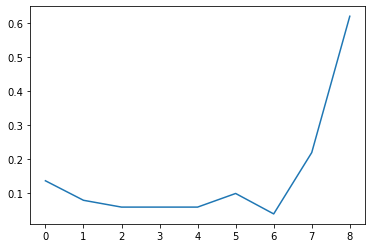

Loss history


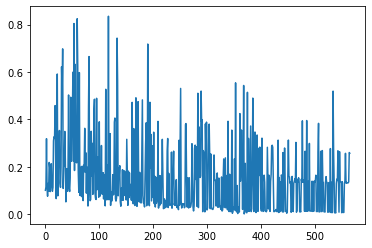

Q-values


Top 10 Q-Values: 
  -( 0 6 1 ) :  -0.06943038
  -( 6 6 1 ) :  -0.069435984
  -( 5 6 1 ) :  -0.06946072
  -( 1 6 1 ) :  -0.06948525
  -( 4 6 1 ) :  -0.06948888
  -( 0 5 1 ) :  -0.06950995
  -( 6 5 1 ) :  -0.069515556
  -( 3 6 1 ) :  -0.06952566
  -( 5 5 1 ) :  -0.06954026
  -( 2 6 1 ) :  -0.06954628
  -( 1 5 1 ) :  -0.06956476
  -( 4 5 1 ) :  -0.069568455
  -( 6 0 1 ) :  -0.06958097
  -( 6 4 1 ) :  -0.06958702
  -( 0 4 1 ) :  -0.069589585
  -( 3 5 1 ) :  -0.06960526
  -( 5 0 1 ) :  -0.0696165
  -( 5 4 1 ) :  -0.069619894
  -( 2 5 1 ) :  -0.069625854
  -( 6 1 1 ) :  -0.06962597
  -( 6 3 1 ) :  -0.06964108
  -( 1 4 1 ) :  -0.06964436
  -( 4 4 1 ) :  -0.06964806
  -( 0 0 1 ) :  -0.069648206
  -( 4 0 1 ) :  -0.069658846
  -( 5 1 1 ) :  -0.06966445
  -( 6 2 1 ) :  -0.06966668
  -( 0 3 1 ) :  -0.06967801
  -( 5 3 1 ) :  -0.06967956
  -( 3 4 1 ) :  -0.06968483
  -( 0 1 1 ) :  -0.069696575
  -( 1 0 1 ) :  -0.06970087
  -( 5 2 1 ) :  -0.06970522
  -( 2 4 1 ) :  -0.06970546
  -( 4 1 1 

In [42]:
print("Reward history")
plt.plot(reward_history)
plt.show()

print("Loss history")
plt.plot(agent.loss)
plt.show()

print("Q-values")
agent.plot_q_values(state)

# Test

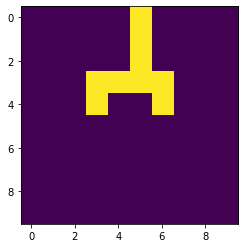

Action:  25
--> place block 0  next to block  6  in relative postion  1
reward:  1





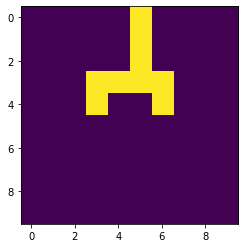

Action:  25
--> place block 0  next to block  6  in relative postion  1
reward:  0





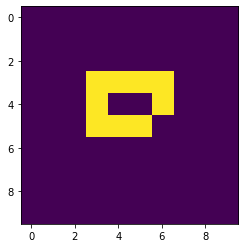

Action:  25
--> place block 0  next to block  6  in relative postion  1
reward:  1





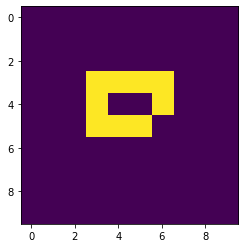

Action:  25
--> place block 0  next to block  6  in relative postion  1
reward:  0





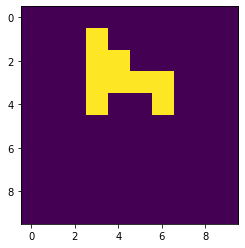

Action:  25
--> place block 0  next to block  6  in relative postion  1
reward:  1





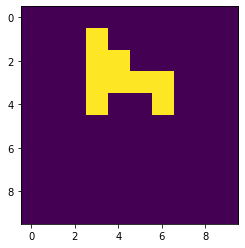

Action:  25
--> place block 0  next to block  6  in relative postion  1
reward:  0





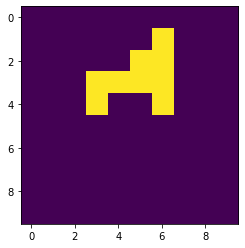

Action:  25
--> place block 0  next to block  6  in relative postion  1
reward:  1





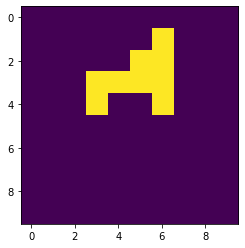

Action:  25
--> place block 0  next to block  6  in relative postion  1
reward:  0





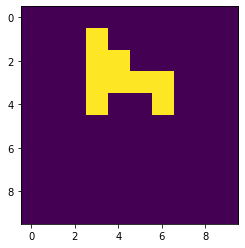

Action:  25
--> place block 0  next to block  6  in relative postion  1
reward:  1





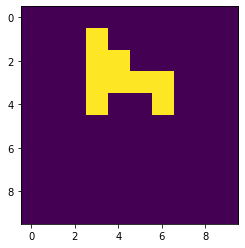

Action:  25
--> place block 0  next to block  6  in relative postion  1
reward:  0





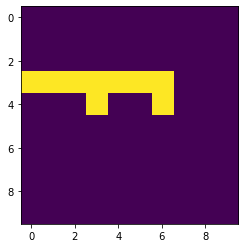

Action:  25
--> place block 0  next to block  6  in relative postion  1
reward:  1





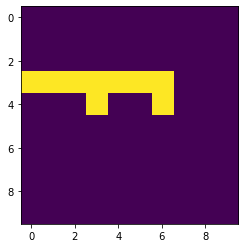

Action:  25
--> place block 0  next to block  6  in relative postion  1
reward:  0





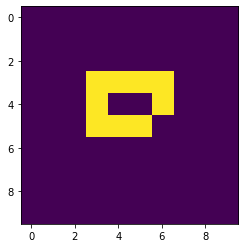

Action:  25
--> place block 0  next to block  6  in relative postion  1
reward:  1





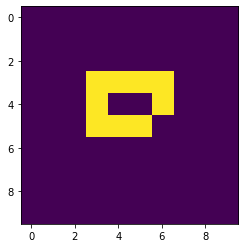

Action:  25
--> place block 0  next to block  6  in relative postion  1
reward:  0





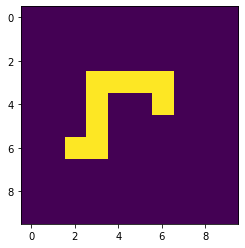

Action:  25
--> place block 0  next to block  6  in relative postion  1
reward:  1





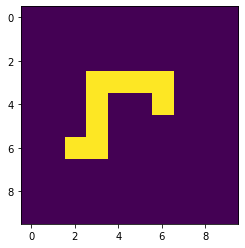

Action:  25
--> place block 0  next to block  6  in relative postion  1
reward:  0





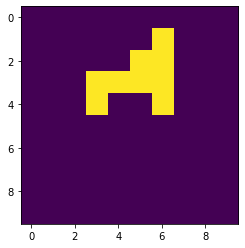

Action:  25
--> place block 0  next to block  6  in relative postion  1
reward:  1





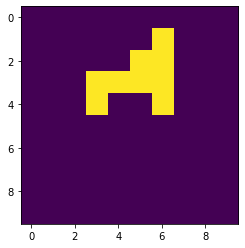

Action:  25
--> place block 0  next to block  6  in relative postion  1
reward:  0





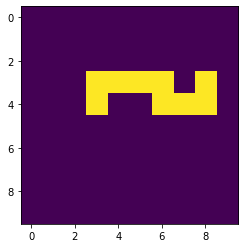

Action:  25
--> place block 0  next to block  6  in relative postion  1
reward:  1





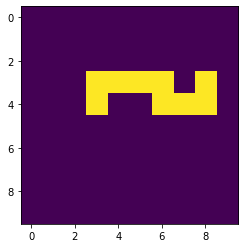

Action:  25
--> place block 0  next to block  6  in relative postion  1
reward:  0





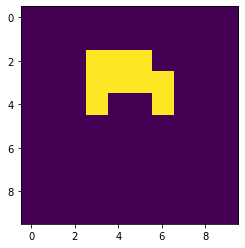

Action:  25
--> place block 0  next to block  6  in relative postion  1
reward:  1





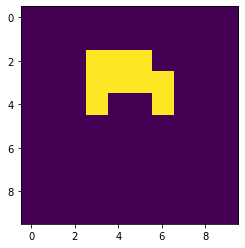

Action:  25
--> place block 0  next to block  6  in relative postion  1
reward:  0





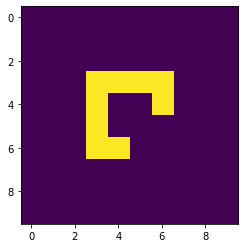

Action:  25
--> place block 0  next to block  6  in relative postion  1
reward:  1





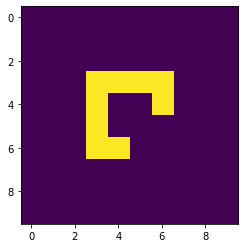

Action:  25
--> place block 0  next to block  6  in relative postion  1
reward:  0





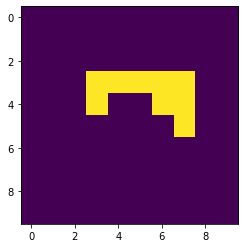

Action:  25
--> place block 0  next to block  6  in relative postion  1
reward:  1





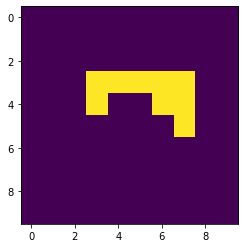

Action:  25
--> place block 0  next to block  6  in relative postion  1
reward:  0





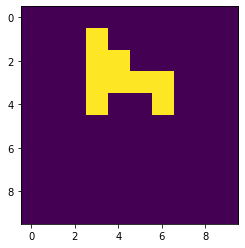

Action:  25
--> place block 0  next to block  6  in relative postion  1
reward:  1





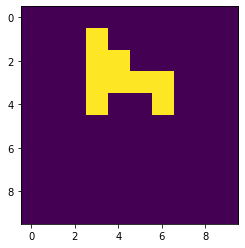

Action:  25
--> place block 0  next to block  6  in relative postion  1
reward:  0





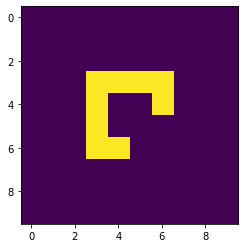

Action:  25
--> place block 0  next to block  6  in relative postion  1
reward:  1





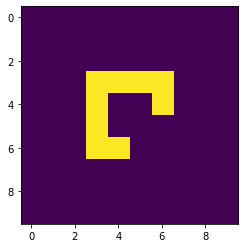

Action:  25
--> place block 0  next to block  6  in relative postion  1
reward:  0





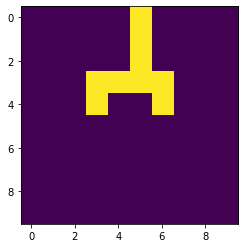

Action:  25
--> place block 0  next to block  6  in relative postion  1
reward:  1





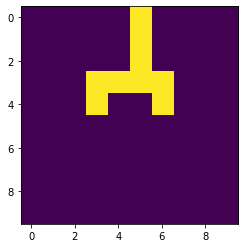

Action:  25
--> place block 0  next to block  6  in relative postion  1
reward:  0





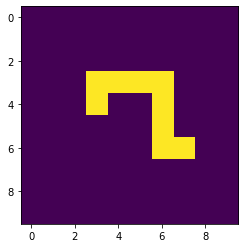

Action:  25
--> place block 0  next to block  6  in relative postion  1
reward:  1





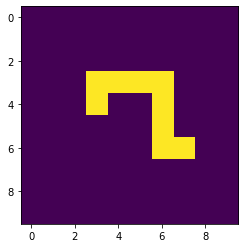

Action:  25
--> place block 0  next to block  6  in relative postion  1
reward:  0





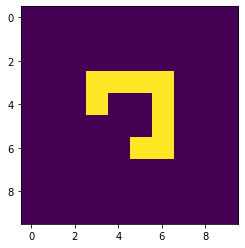

Action:  25
--> place block 0  next to block  6  in relative postion  1
reward:  1





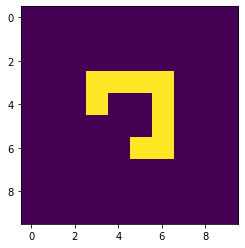

Action:  25
--> place block 0  next to block  6  in relative postion  1
reward:  0





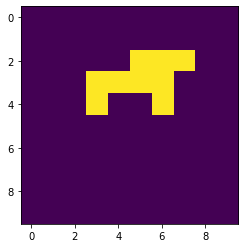

Action:  25
--> place block 0  next to block  6  in relative postion  1
reward:  1





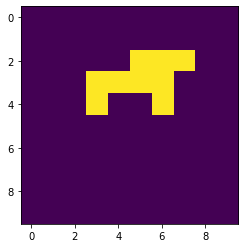

Action:  25
--> place block 0  next to block  6  in relative postion  1
reward:  0





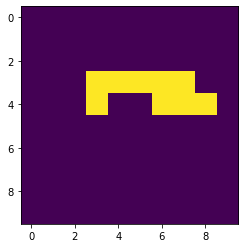

Action:  25
--> place block 0  next to block  6  in relative postion  1
reward:  1





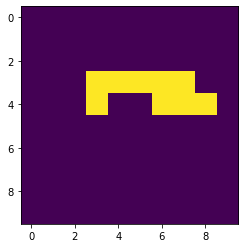

Action:  25
--> place block 0  next to block  6  in relative postion  1
reward:  0


In [38]:
#agent = Agent()
#agent.load("train/model_99000_0.0.pt")
agent.epsilon = 0
env = Env(silhouettes)
g = env.reset()

for i in range(20):
    state = env.reset()
    done = False
    total_reward = 0
    while not done:
        
        print("\n\n")
        silhouette = state[2]
        plt.imshow(silhouette)
        plt.show()
        
        action = agent.choose_action(state)
        
        #print(action)
        sender = action // 28
        receiver = (action-sender*28) // 4
        rel_pos = action % 4
        
        print("Action: ", action)
        print("--> place block", sender, " next to block ", receiver, " in relative postion ", rel_pos)
        
        #print(sender,receiver,rel_pos)
        
        next_state,reward,done = env.step((sender,receiver,rel_pos))
        total_reward += reward
        print("reward: ", reward)
        
        #agent.store_transition(state, action, reward, next_state, done)
        #agent.learn()
        state = next_state




# Sanity Check

In [78]:
agent = Agent()
n_games = 1000
eps_decay = 1/round(n_games*0.8)
agent.eps_dec = eps_decay
reward_history = []
stat = []
env = TestEnv(silhouettes)
start_time = time.time()
filename = 'train/train_dqn.txt'
file = open(filename, 'w')
file.write("##########################################\n")
file.write("n_games = " + str(n_games)+"\n")
file.write("batch_size = " +  str(agent.batch_size) +"\n")
file.write("eps_decay = " + str(agent.eps_dec) + "\n")
file.write("buffer_size = " +str(agent.max_memory) + "\n")
file.write("##########################################\n\n\n")
file.close()


for i in range(n_games):
    state = env.reset()
    done = False
    total_reward = 0
    while not done:
        #print("\n\n #### Game: ", i, " ####")
        action = agent.choose_action(state)
        
        #print(action)
        sender = action // 28
        receiver = (action-sender*28) // 4
        rel_pos = action % 4
        #print(sender,receiver,rel_pos)
        
        next_state,reward,done = env.step((sender,receiver,rel_pos))
        total_reward += reward
        
        #print("Action: ", action, "Reward: ", reward)
        
        agent.store_transition(state, action, reward, next_state, done)
        agent.learn()
        state = next_state
        
        
    stat.append(total_reward)
    if i % 50==0 an i > 0:
        print("Game #", i, "reward: ", np.mean(stat), "   eps: ",agent.epsilon, "time: ",round(time.time()-start_time, 2))
        file = open(filename, 'a')
        file.write("Game #" + str(i) +  "  reward: " + str(np.mean(stat)) + "   eps: " + str(agent.epsilon) + "  time: " + str(round(time.time()-start_time, 2))+"\n")
        file.close()
        
        #agent.plot_q_values(state)
        
        
        if i % 1000==0 and i > 0:
            model_path = "train/model_"+str(i)+"_"+str(np.mean(stat))+".pt"
            agent.save(model_path)
            
        reward_history.append(np.mean(stat))
        stat = []
        start_time = time.time()

        

Game # 0 reward:  2.0    eps:  1 time:  0.0
Game # 50 reward:  0.5    eps:  0.8175000000000039 time:  43.89
Game # 100 reward:  0.94    eps:  0.6300000000000079 time:  52.61
Game # 150 reward:  1.58    eps:  0.4425000000000119 time:  50.76
Game # 200 reward:  1.12    eps:  0.2550000000000159 time:  51.12
Game # 250 reward:  1.0    eps:  0.06750000000001583 time:  51.04
Game # 300 reward:  2.14    eps:  0.01 time:  52.02
Game # 350 reward:  2.44    eps:  0.01 time:  51.85
Game # 400 reward:  2.66    eps:  0.01 time:  49.97
Game # 450 reward:  2.8    eps:  0.01 time:  50.07
Game # 500 reward:  2.94    eps:  0.01 time:  49.99
Game # 550 reward:  2.94    eps:  0.01 time:  50.98
Game # 600 reward:  2.92    eps:  0.01 time:  49.74


KeyboardInterrupt: 

Reward history


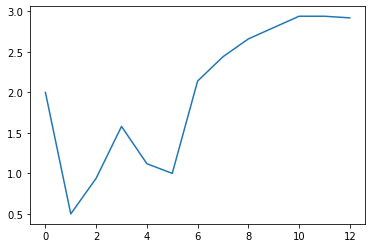

Loss history


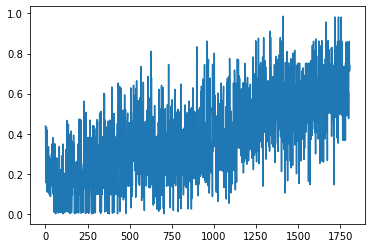

In [80]:
print("Reward history")
plt.plot(reward_history)
plt.show()

print("Loss history")
plt.plot(agent.loss)
plt.show()
